# Early Identification of Underperforming Students



## Main Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
pd.set_option('mode.chained_assignment', None)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.graphics.mosaicplot import mosaic

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load the data

In [2]:
main_path = '/content/drive/My Drive/University Work/Year 4/Learning Analytics/'

studentAssessment = pd.read_csv(main_path + 'data/studentAssessment.csv')
studentVle1 = pd.read_csv(main_path + 'data/studentVle.csv', engine='python')
studentVle2 = pd.read_csv(main_path + 'data/studentVle.csv')
vle = pd.read_csv(main_path + 'data/vle.csv')
studentRegistration = pd.read_csv(main_path + 'data/studentRegistration.csv')
courses = pd.read_csv(main_path + 'data/courses.csv')
studentInfo = pd.read_csv(main_path + 'data/studentInfo.csv')
assessments = pd.read_csv(main_path + 'data/assessments.csv')

## Use registration info (date signed up), demographic, stuff from this
#https://dl.acm.org/doi/pdf/10.1145/3027385.3027449

## Descriptive Analytics

### Plot the distribution of final results

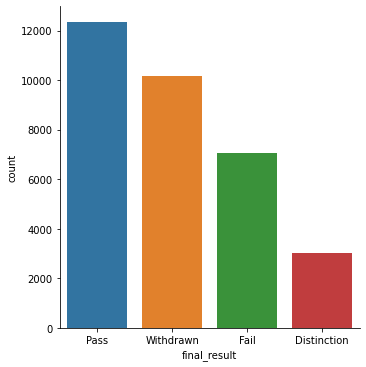

In [ ]:
sns.catplot(x="final_result", data=studentInfo, kind="count", height=5)

### Plot distribution after condensing data into Pass (Pass + Distinction) or Fail

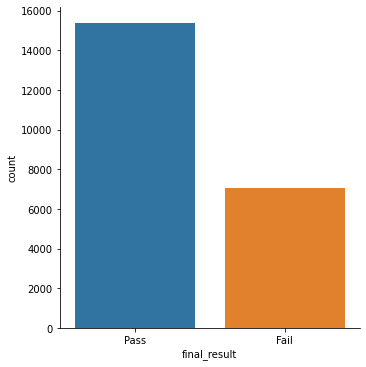

In [3]:
pass_fail_info = studentInfo[studentInfo['final_result'] != 'Withdrawn']
labels = {
    'Pass': 'Pass',
    'Fail': 'Fail',
    'Distinction': 'Pass'
}
pass_fail_info['final_result'] = pass_fail_info['final_result'].map(labels)
sns.catplot(x="final_result", data=pass_fail_info, kind="count", height=5)

### Plot the correlation between level of education and number of credits taken

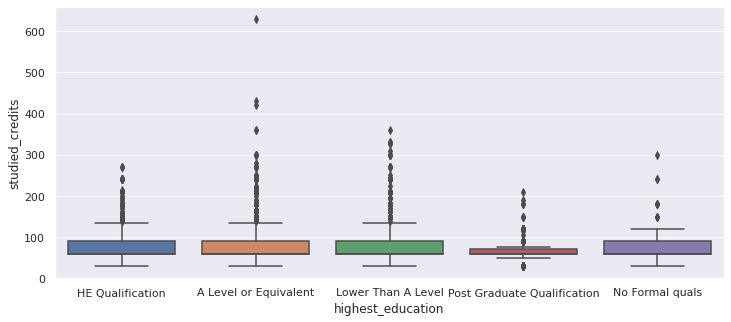

In [ ]:
sns.set(rc={'figure.figsize':(12, 5)})
sns.boxplot(x = 'highest_education', y = 'studied_credits', data=pass_fail_info)

### Plot the correlation between region and IMD band

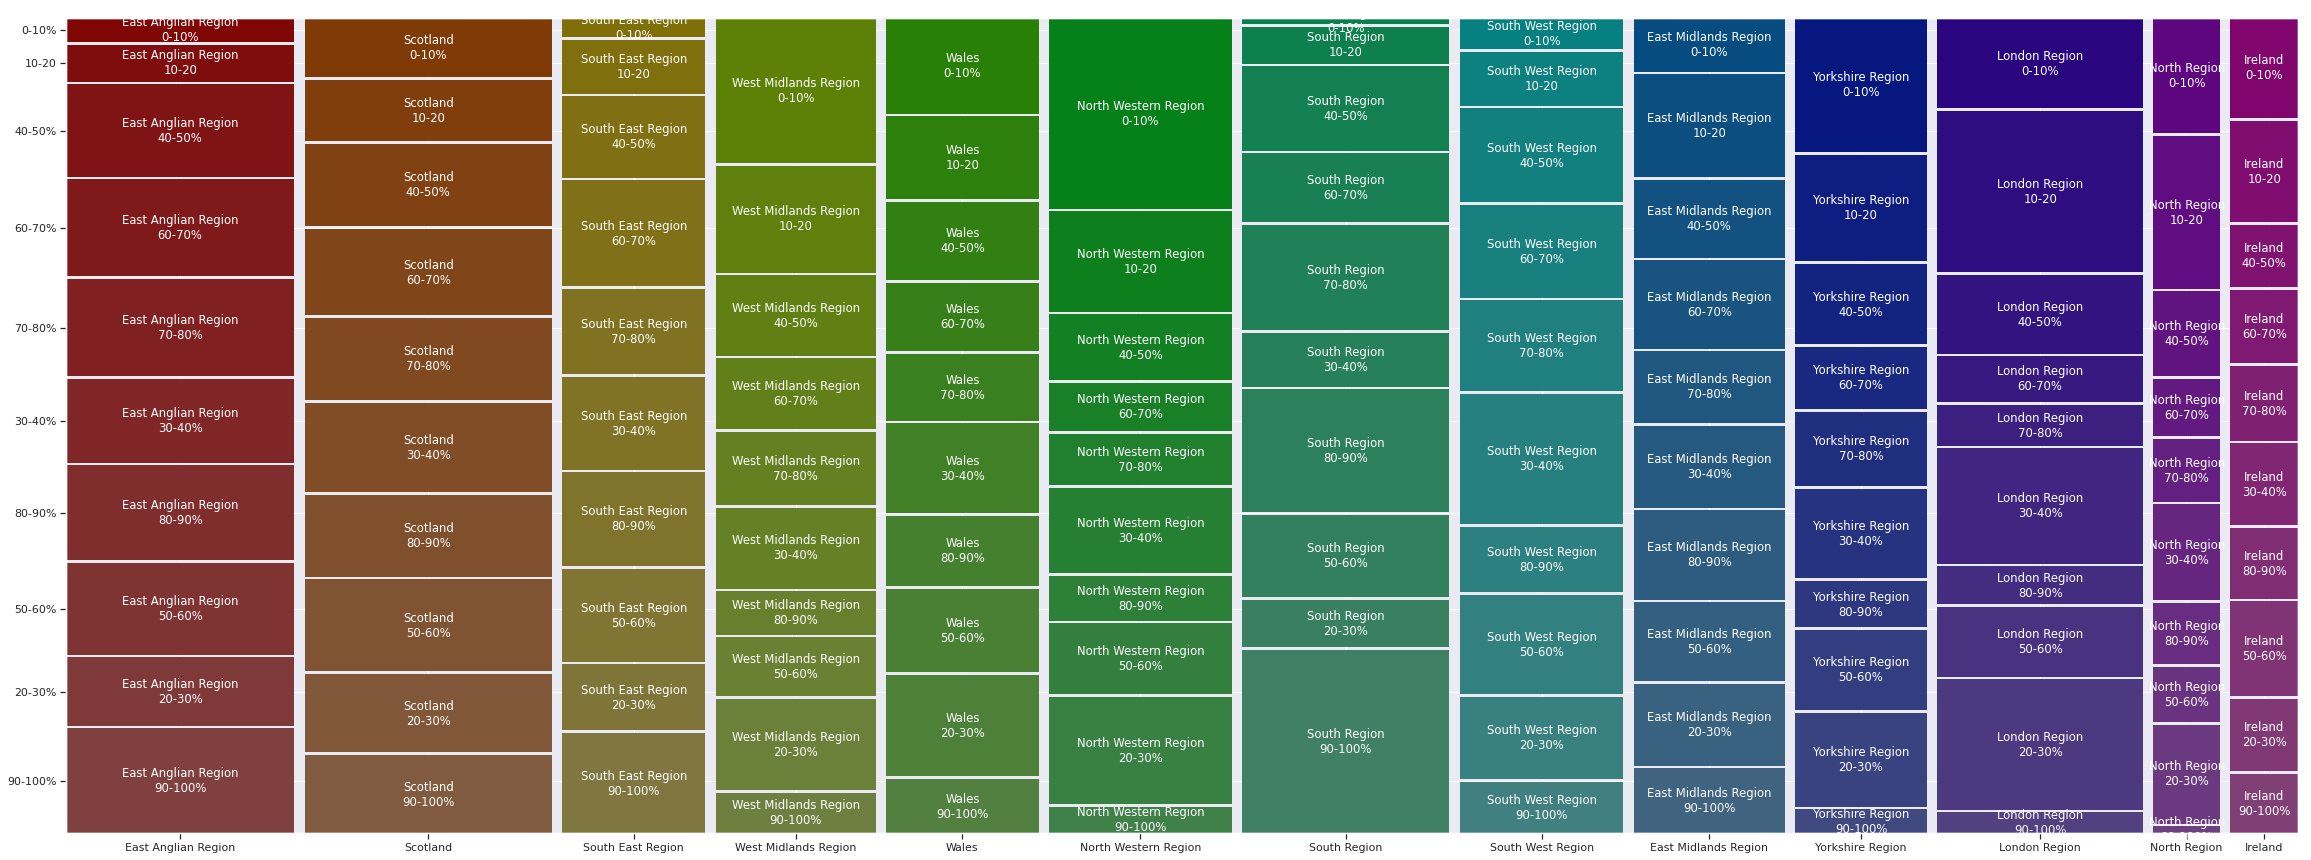

In [ ]:
plt.rcParams["figure.figsize"] = (40, 15)
plt.rcParams['font.size'] = 14.0
plt.rcParams['text.color'] = 'white'
mosaic(pass_fail_info, ['region', 'imd_band']);

### Merge the dataframes to have number of clicks and result in same df

In [9]:
merged_df = pd.merge(pass_fail_info, studentVle1, on=['id_student', 'code_module', 'code_presentation'])
merged_df = merged_df[['id_student', 'id_site', 'date', 'sum_click', 'final_result']]
pass_fail_click_df = merged_df.groupby(merged_df.index).aggregate({'id_student': 'first', 'id_site': 'first', 'date': 'first', 'sum_click': 'sum', 'final_result': 'first'})
pass_fail_click_df

,id_student,id_site,date,sum_click,final_result
0,11391,546669,-5,16,Pass
1,11391,546662,-5,44,Pass
2,11391,546652,-5,1,Pass
3,11391,546668,-5,2,Pass
4,11391,546652,-5,1,Pass
...,...,...,...,...,...
11990,2698257,546652,2,2,Pass
11991,2698257,546986,2,1,Pass
11992,2698257,546652,2,3,Pass
11993,2698257,546662,2,11,Pass


### Plot a scatterplot showing correlation between number of clicks and pass/fail

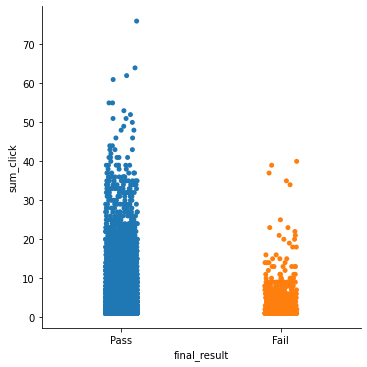

In [10]:
sns.catplot(x="final_result", y="sum_click", data=pass_fail_click_df, height=5)

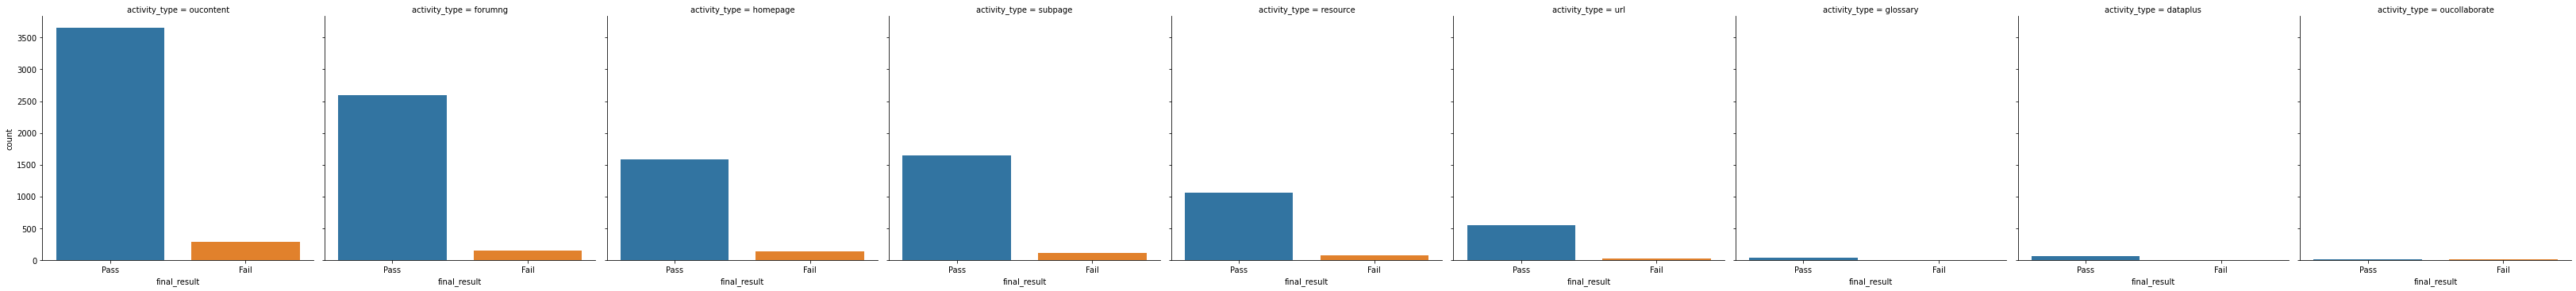

In [11]:
pass_fail_click_activity_df = pd.merge(pass_fail_click_df, vle, on=['id_site'])
sns.catplot(x="final_result", col="activity_type", data=pass_fail_click_activity_df, kind="count", height=5)